# MODEL USING DATAIMAGEGENERATOR

IMPORTANT TO NOTE: The way the generator works is through subdivided folders that it assigns to "0" or "1", in this case it assigned the reverse of the previous models so "0" is clean and "1" is polluted

***See train_generator.__dict__, validation_generator.__dict__ on bottom of page for interpretation of classes***

In [157]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 1360
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # see the value of multiple statements at once.
pd.set_option('display.max_columns', None)

from PIL import Image, ImageFilter
import PIL as pillow

import random
import cv2, os, glob
from glob import glob
seed = 42
np.random.seed(seed)
from tqdm import tqdm

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras import backend as K
from random import sample
from scipy.misc import imresize
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
K.set_image_dim_ordering('th')
from sklearn.metrics import confusion_matrix, classification_report



In [618]:
# import PIL as pillow
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn import svm
# import os
# import pandas as pd
# import itertools as it
# #np.random.seed(123)  # for reproducibility

# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, Flatten
# from keras.layers import Convolution2D, MaxPooling2D
# from keras.utils import np_utils
# from keras.datasets import mnist
# import cv2


In [2]:
df = pd.read_excel('ne_10m_lakes.xlsx', sheet="sheet1")

In [3]:
img= df.iloc[2,6]
name = df.iloc[2,9]+'.jpg'
name

'Engozero.jpg'

# Data Cleaning

In [4]:
df = pd.read_csv('./good_coords.csv')
df.head()

,HouseNumber,Address,City,State,Country,PostCode,County,Latitude,Longitude,name,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,NaN,NaN,Wiley,British Columbia,Canada,V9N 1P9,NaN,67.415533,-126.377694,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,Marsh lake,Yukon,Canada,Y0B 1T0,NaN,59.982692,-134.179318,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,Truly,Montana,Canada,T9K 0K4,NaN,64.971428,-111.432358,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,Sayward,British Columbia,Canada,V0J 2T0,NaN,67.186371,-125.982007,Colville Lake,NaN,NaN,NaN,NaN
4,0.0,Winter Trl,Kotlik,AK,United States,99620-0316,Wade Hampton,62.639328,-163.556980,NaN,NaN,NaN,NaN,NaN


In [5]:
df1 = df.filter(items=['Country'], axis=1)
df1.head()

,Country
0,Canada
1,Canada
2,Canada
3,Canada
4,United States


In [6]:
df2 = pd.read_csv('./count_WQI.csv')
df2.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,Argentina,84.27,NaN,NaN,NaN,NaN,NaN
1,Armenia,51.04,NaN,NaN,NaN,NaN,NaN
2,Australia,61.74,NaN,NaN,NaN,NaN,NaN
3,Azerbaijan,44.28,NaN,NaN,NaN,NaN,NaN
4,Bangladesh,87.16,NaN,NaN,NaN,NaN,NaN


In [7]:
df2.rename(columns={'Unnamed: 0':'Country', 'Unnamed: 1':'WQI'}, inplace=True)
df2.head()

,Country,WQI,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,Argentina,84.27,NaN,NaN,NaN,NaN,NaN
1,Armenia,51.04,NaN,NaN,NaN,NaN,NaN
2,Australia,61.74,NaN,NaN,NaN,NaN,NaN
3,Azerbaijan,44.28,NaN,NaN,NaN,NaN,NaN
4,Bangladesh,87.16,NaN,NaN,NaN,NaN,NaN


In [8]:
df3 = pd.merge(df,df2, left_on=['Country'],right_on=['Country'], how='left', indicator=True)
df3.head()

,HouseNumber,Address,City,State,Country,PostCode,County,Latitude,Longitude,name,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,WQI,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,_merge
0,NaN,NaN,Wiley,British Columbia,Canada,V9N 1P9,NaN,67.415533,-126.377694,NaN,NaN,NaN,NaN,NaN,93.11,NaN,NaN,NaN,NaN,NaN,both
1,NaN,NaN,Marsh lake,Yukon,Canada,Y0B 1T0,NaN,59.982692,-134.179318,NaN,NaN,NaN,NaN,NaN,93.11,NaN,NaN,NaN,NaN,NaN,both
2,NaN,NaN,Truly,Montana,Canada,T9K 0K4,NaN,64.971428,-111.432358,NaN,NaN,NaN,NaN,NaN,93.11,NaN,NaN,NaN,NaN,NaN,both
3,NaN,NaN,Sayward,British Columbia,Canada,V0J 2T0,NaN,67.186371,-125.982007,Colville Lake,NaN,NaN,NaN,NaN,93.11,NaN,NaN,NaN,NaN,NaN,both
4,0.0,Winter Trl,Kotlik,AK,United States,99620-0316,Wade Hampton,62.639328,-163.556980,NaN,NaN,NaN,NaN,NaN,77.47,NaN,NaN,NaN,NaN,NaN,both


# Final Dataframe

In [9]:
df4 = df3[['Latitude', 'Longitude', 'Country', 'name', 'WQI']]
df4.head()

,Latitude,Longitude,Country,name,WQI
0,67.415533,-126.377694,Canada,NaN,93.11
1,59.982692,-134.179318,Canada,NaN,93.11
2,64.971428,-111.432358,Canada,NaN,93.11
3,67.186371,-125.982007,Canada,Colville Lake,93.11
4,62.639328,-163.556980,United States,NaN,77.47


# Separating Data into Train and Test 

In [10]:
df4['Images'] = df4['Longitude'].map(lambda x: str(x) + '.jpg')
df4['train_test'] = 'train'
df4['train_test'].iloc[::5] = 'test'
df4.head(20)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

,Latitude,Longitude,Country,name,WQI,Images,train_test
0,67.415533,-126.377694,Canada,NaN,93.11,-126.377694045249.jpg,test
1,59.982692,-134.179318,Canada,NaN,93.11,-134.179317812668.jpg,train
2,64.971428,-111.432358,Canada,NaN,93.11,-111.432358446463.jpg,train
3,67.186371,-125.982007,Canada,Colville Lake,93.11,-125.98200712226401.jpg,train
4,62.639328,-163.556980,United States,NaN,77.47,-163.556980334003.jpg,train
5,55.418135,-104.341226,Canada,NaN,93.11,-104.34122646468799.jpg,test
6,65.878953,-112.300403,Canada,NaN,93.11,-112.300403496523.jpg,train
7,50.217162,-94.382672,Canada,NaN,93.11,-94.3826717298093.jpg,train
8,65.038837,-118.595150,Canada,Hottah Lake,93.11,-118.595150417946.jpg,train
9,48.461722,-80.997832,Canada,NaN,93.11,-80.99783173624608.jpg,train


WQI= source http://waterriskfilter.panda.org/en/CountryProfiles#1/profileDescription:
Subindex of the Environmental Performance Index (EPI). It uses three parameters measuring nutrient levels (Dissolved Oxygen, Total Nitrogen, and Total Phosphorus) and two parameters measuring water chemistry (pH and Conductivity). These parameters were selected because they cover issues of global relevance (eutrophication, nutrient pollution, acidification, and salinization) and because they are the most consistently reported.
Source: 
Link: http://epi.yale.edu/

In [247]:
df4.dtypes

Latitude      float64
Longitude     float64
Country        object
name           object
WQI             int64
Images         object
train_test     object
dtype: object

# Setting the Threshold
Making Water Quality Index into a binary classification based on threshold

In [11]:
df4['WQI'] = df4['WQI'].map(lambda x: 1 if x>65.0 else 0)
df4

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Latitude,Longitude,Country,name,WQI,Images,train_test
0,67.415533,-126.377694,Canada,NaN,1,-126.377694045249.jpg,test
1,59.982692,-134.179318,Canada,NaN,1,-134.179317812668.jpg,train
2,64.971428,-111.432358,Canada,NaN,1,-111.432358446463.jpg,train
3,67.186371,-125.982007,Canada,Colville Lake,1,-125.98200712226401.jpg,train
4,62.639328,-163.556980,United States,NaN,1,-163.556980334003.jpg,train
5,55.418135,-104.341226,Canada,NaN,1,-104.34122646468799.jpg,test
6,65.878953,-112.300403,Canada,NaN,1,-112.300403496523.jpg,train
7,50.217162,-94.382672,Canada,NaN,1,-94.3826717298093.jpg,train
8,65.038837,-118.595150,Canada,Hottah Lake,1,-118.595150417946.jpg,train
9,48.461722,-80.997832,Canada,NaN,1,-80.99783173624608.jpg,train


In [84]:
df4.shape

(1354, 8)

In [12]:
df4.WQI.mean()

0.8330871491875923

In [13]:
df4.WQI.value_counts()

1    1128
0     226
Name: WQI, dtype: int64

In [70]:
PATHTRAIN = os.path.abspath(os.path.join('./Pics_by_lat'))
source_images_train = os.listdir(PATHTRAIN) 
PATHTEST = os.path.abspath(os.path.join('./Test_Images'))
source_images_test = os.listdir(PATHTEST) 
#print('train images:',source_images_train[0:3])
#print('test images:',source_images_test[0:3])

In [71]:
cols_to_keep = ['WQI','Images','train_test']
df4= df4[cols_to_keep]

train = df4[df4['train_test'] == 'train']   # Rows in the (total Kaggle) train set
test = df4[df4['train_test'] == 'test']   # Rows in the testing set

print(train.shape)

print(test.shape)


(1083, 3)
(271, 3)


In [21]:
train['Images'].tolist()[0:2]

['-134.179317812668.jpg', '-111.432358446463.jpg']

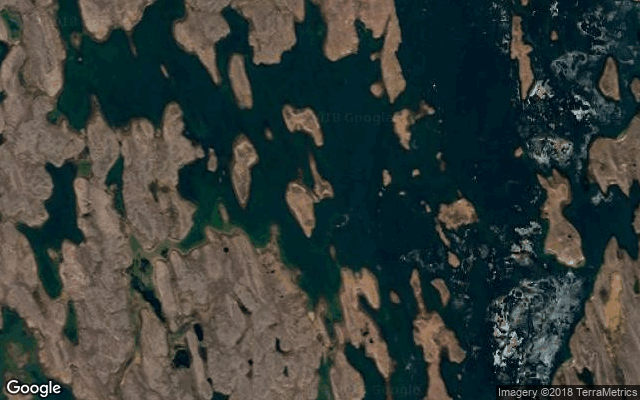

In [22]:
img = load_img(os.path.join(PATHTRAIN,source_images_train[7])) 
img

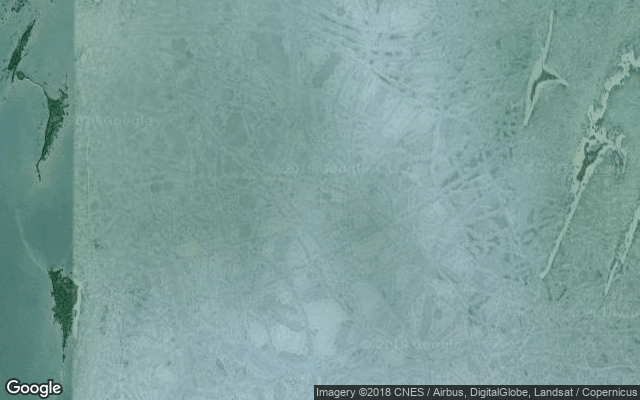

In [23]:
img_2 = load_img(os.path.join(PATHTEST,source_images_test[0]))
img_2

In [24]:
os.listdir(PATHTRAIN)

['-100.204100308034.jpg',
 '-100.355534097749.jpg',
 '-100.42862704389.jpg',
 '-100.458946293738.jpg',
 '-100.506977291747.jpg',
 '-100.555525705575.jpg',
 '-100.78698383198.jpg',
 '-100.859236332062.jpg',
 '-101.077189173698.jpg',
 '-101.138890128492.jpg',
 '-101.225920433054.jpg',
 '-101.38983879088.jpg',
 '-101.655519729526.jpg',
 '-101.656513153124.jpg',
 '-101.687682799391.jpg',
 '-101.689025922872.jpg',
 '-101.771460328576.jpg',
 '-101.824344231992.jpg',
 '-101.863083179338.jpg',
 '-101.996172560318.jpg',
 '-102.211299120928.jpg',
 '-102.227357147259.jpg',
 '-102.301896818829.jpg',
 '-102.316042141072.jpg',
 '-102.347052827372.jpg',
 '-102.353130360152.jpg',
 '-102.583179298982.jpg',
 '-102.820797613811.jpg',
 '-102.970992375056.jpg',
 '-103.020935036998.jpg',
 '-103.043322029609.jpg',
 '-103.045388890853.jpg',
 '-103.127266718821.jpg',
 '-103.2448406642.jpg',
 '-103.340301534505.jpg',
 '-103.368325824542.jpg',
 '-103.372343680271.jpg',
 '-103.491792773045.jpg',
 '-103.6293715826

In [72]:
train_polluted = train[train['WQI'] == 0]
train_clean = train[train['WQI'] == 1]
test_polluted = test[test['WQI'] == 0]
test_clean = test[test['WQI'] == 1]

In [26]:
train_polluted.Images

16      -105.46817844133498.jpg
38         -5.0873014838046.jpg
68       30.892245709534603.jpg
77      -105.04433517407601.jpg
84       2.4656417247380698.jpg
127        31.5081864241111.jpg
131      61.607582565811605.jpg
134        45.3627400485852.jpg
149       92.76862124220659.jpg
161      37.772777377530105.jpg
202       -100.204100308034.jpg
204        26.3963531876201.jpg
211       77.63238547657609.jpg
212        83.4350769928513.jpg
226        37.3821976920955.jpg
243     -103.04332202960899.jpg
268        72.9384376932763.jpg
279        29.9243223985814.jpg
281      43.440854833440895.jpg
298      4.5654831197025905.jpg
336        137.298600313602.jpg
337       -105.441287664631.jpg
362        43.2224941954673.jpg
369        34.0675356175121.jpg
371        43.5720026213699.jpg
394       -89.0315185686819.jpg
402       -88.7723639309152.jpg
406      38.416073347932205.jpg
412        35.4778479489184.jpg
428       38.80534340233589.jpg
433     -109.35321944810998.jpg
441     

Creating Sub-Folders of Train: clean, polluted and Test: clean, polluted to be used 
for imagedatagenerator

In [607]:
#%mkdir './Pics_by_lat_new'

In [685]:
# %mkdir './Pics_by_lat_new/train_polluted'
# %mkdir './Pics_by_lat_new/train_clean'

In [609]:
def subfolder_maker(PATHTRAIN,PATHDUMP,
                    PATHDUMPNOT,original_images,
                    original_images_not):
    for image_filename in tqdm(os.listdir(PATHTRAIN)[1:]):         
        img = Image.open(os.path.join(PATHTRAIN, 
                                      image_filename)).convert('RGB')  # PATH contains all training or testing set
        
        if image_filename in original_images:           # original_images contains all
#             print(os.path.join(PATHDUMP, 
#                                   image_filename))
            img.save(os.path.join(PATHDUMP, 
                                  image_filename))      
        elif image_filename in original_images_not:
            img.save(os.path.join(PATHDUMPNOT, 
                                  image_filename))            

In [610]:
PATHTRAIN = os.path.abspath('./Pics_by_lat')
PATHDUMPCLEANTRAIN= os.path.abspath('./Pics_by_lat_new/train_clean')
PATHDUMPPOLLUTEDTRAIN = os.path.abspath('./Pics_by_lat_new/train_polluted')
subfolder_maker(PATHTRAIN,PATHDUMPCLEANTRAIN,
                    PATHDUMPPOLLUTEDTRAIN,train_clean['Images'].tolist(),
                train_polluted['Images'].tolist())

100%|██████████| 1081/1081 [00:19<00:00, 56.43it/s]


In [44]:
%mkdir './Test_Images_new1'
%mkdir './Test_Images_new1/test_polluted1'
%mkdir './Test_Images_new1/test_clean1'

mkdir: ./Test_Images_new1: File exists


In [47]:
def subfolder_maker(PATHTEST,PATHDUMP,
                    PATHDUMPNOT,original_images,
                    original_images_not):
    for image_filename in tqdm(os.listdir(PATHTEST)[1:]):          
        img = Image.open(os.path.join(PATHTEST, 
                                      image_filename)).convert('RGB')  # PATH contains all training or testing set
        
        if image_filename in original_images:           
#             
            img.save(os.path.join(PATHDUMP, 
                                  image_filename))     
        elif image_filename in original_images_not:
            img.save(os.path.join(PATHDUMPNOT, 
                                  image_filename)) 

In [48]:
PATHTEST = os.path.abspath('./Test_Images_Double_Images')
PATHDUMPCLEANTEST= os.path.abspath('./Test_Images_new1/test_clean1')
PATHDUMPPOLLUTEDTEST = os.path.abspath('./Test_Images_new1/test_polluted1')
subfolder_maker(PATHTEST,PATHDUMPCLEANTEST,PATHDUMPPOLLUTEDTEST,
                test_clean['Images'].tolist(),
                test_polluted['Images'].tolist())

 36%|███▋      | 195/535 [00:00<00:01, 272.27it/s]/anaconda3/lib/python3.6/site-packages/PIL/Image.py:888: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
100%|██████████| 535/535 [00:01<00:00, 283.48it/s]


source_images_train[0:2]
print(PATHTRAIN)
print(PATHDUMPCLEANTRAIN)
print(PATHDUMPPOLLUTEDTRAIN)

In [48]:
train_clean['Images'].tolist()[0:2]

['-134.179317812668.jpg', '-111.432358446463.jpg']

print(source_images_train[0:2])
print(PATHTRAIN)
print(PATHDUMPCLEANTRAIN)
print(PATHDUMPPOLLUTEDTRAIN)
print(train_clean['Images'].tolist()[0:2])
print(train_polluted['Images'].tolist()[0:2])

In [59]:
train_clean.head()

,WQI,Images,train_test
1,1,-134.179317812668.jpg,train
2,1,-111.432358446463.jpg,train
3,1,-125.98200712226401.jpg,train
4,1,-163.556980334003.jpg,train
6,1,-112.300403496523.jpg,train


In [58]:
train_polluted.head()

,WQI,Images,train_test
16,0,-105.46817844133498.jpg,train
38,0,-5.0873014838046.jpg,train
68,0,30.892245709534603.jpg,train
77,0,-105.04433517407601.jpg,train
84,0,2.4656417247380698.jpg,train


In [51]:
test_clean.head()

,WQI,Images,train_test
0,1,-126.377694045249.jpg,test
5,1,-104.34122646468799.jpg,test
10,1,-106.62629847051001.jpg,test
15,1,-107.28834133199.jpg,test
20,1,-92.8722295766169.jpg,test


In [49]:
test_polluted.head()

,WQI,Images,train_test
195,0,-100.55552570557501.jpg,test
230,0,-89.06119396567459.jpg,test
255,0,-86.39916967100159.jpg,test
355,0,-101.824344231992.jpg,test
375,0,-92.5488919361839.jpg,test


# Preview of ImageDataGenerator for one image

In [53]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.8,
        horizontal_flip=True,
        fill_mode='nearest')

In [56]:
%mkdir './Pics_by_lat/preview'

In [57]:
PATHPREVIEW = '/Users/tovahirsch/Desktop/Capstone/Pics_by_lat/preview'

In [58]:
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('/Users/tovahirsch/Desktop/Capstone/Pics_by_lat/-98.7457218414528.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='/Users/tovahirsch/Desktop/Capstone/Pics_by_lat/preview' 
                          , save_prefix='lake', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [64]:
PATHPREVIEW = '/Users/tovahirsch/Desktop/Capstone/Pics_by_lat/preview'
x = img_to_array(img) 
print('x shape is:',x.shape)

x shape is: (3, 400, 640)


In [60]:
x = x.reshape((1,) + x.shape) 
print('new x shape is:',x.shape)


new x shape is: (1, 3, 400, 640)


What the Generator does:
Original Image

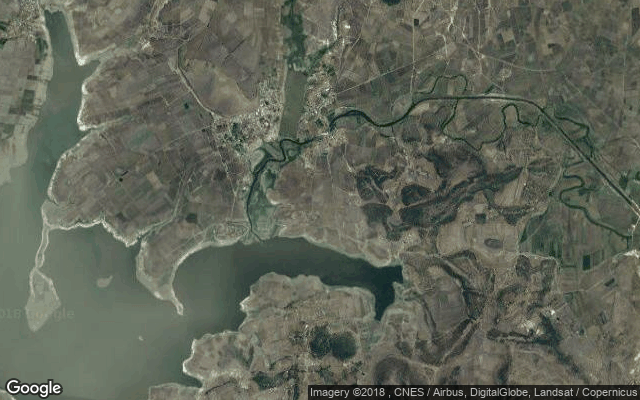

In [60]:
img = load_img('/Users/tovahirsch/Desktop/Capstone/Pics_by_lat/-100.204100308034.jpg')
img

Generated Images:

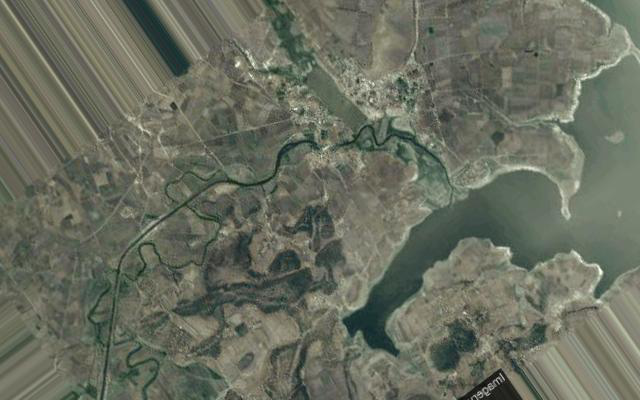

In [62]:
img_2 = load_img('/Users/tovahirsch/Desktop/Capstone/preview/lake_0_1202.jpeg')
img_2

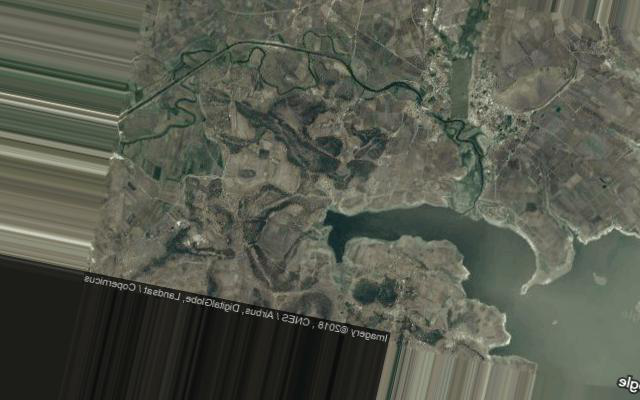

In [63]:
img_2 = load_img('/Users/tovahirsch/Desktop/Capstone/preview/-100_0_5539.jpg')
img_2


In [61]:
os.path.join(PATHTRAIN,source_images_train[2])

'/Users/tovahirsch/Desktop/Capstone/Pics_by_lat/-100.42862704389.jpg'

In [62]:
print('Name of the image file is: ',source_images_train[0])
print("Name of the image file without file format '.' is",source_images_train[0].split('.')[0])

Name of the image file is:  -100.204100308034.jpg
Name of the image file without file format '.' is -100


In [431]:
# fl = 3  # file number from source_images_train
# i = 0
# for batch in train_datagen.flow(x, batch_size=1,
#                           save_to_dir= PATHPREVIEW, 
#                           save_prefix= source_images_train[fl].split('.')[0], 
#                           save_format='jpg'):
#     i += 1
#     if i > 20:
#         break  # to prevent the generator to loop forever

In [131]:
train_data_dir = '/Users/tovahirsch/Desktop/Capstone/Pics_by_lat_new1'
validation_data_dir = '/Users/tovahirsch/Desktop/Capstone/Test_Images_new1'
#train_data_dir
#validation_data_dir
nb_train_samples = len(train_clean['Images'].tolist())+len(train_polluted['Images'].tolist())
nb_validation_samples = len(test_clean['Images'].tolist())+len(test_polluted['Images'].tolist())
epochs = 40
batch_size = 32

#if K.image_data_format() == 'channels_first':
input_shape = (3, 350, 350)
# else:
#     input_shape = (img_width, img_height, 3)

# MODEL WITH SENSITIVITY & SPECIFICITY METRICS

In [199]:
#set up model
model = Sequential()

model.add(Conv2D(filters = 6, kernel_size = 7, activation='relu', input_shape=input_shape)) 
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Conv2D(12, kernel_size = 5, activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(16, kernel_size = 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Conv2D(6, kernel_size = 3, activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Convolution2D(8, kernel_size = 3, activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

from keras import backend as K

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())
model.compile('adam', loss='binary_crossentropy', metrics=[sensitivity, specificity])

In [200]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 6, 344, 344)       888       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 6, 86, 86)         0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 12, 82, 82)        1812      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 12, 27, 27)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 16, 25, 25)        1744      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 16, 12, 12)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 16, 12, 12)        0         
__________

In [134]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        #shear_range=0.2,
        zoom_range=0.4,
        horizontal_flip=True,
        fill_mode='nearest')

In [135]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(350, 350),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(350, 350),
    batch_size=batch_size,
    class_mode='binary')

history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    class_weight={0 : 2., 1: 1.})  

#model.save_weights('first_try.h5')

Found 563 images belonging to 2 classes.
Found 242 images belonging to 2 classes.
Epoch 1/40
32/33 [============================>.] - ETA: 15s - loss: 0.7646 - sensitivity: 0.0208 - specificity: 0.9832

/anaconda3/lib/python3.6/site-packages/PIL/Image.py:888: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


33/33 [==============================] - 583s 18s/step - loss: 0.7590 - sensitivity: 0.0202 - specificity: 0.9837 - val_loss: 0.3710 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 2/40
33/33 [==============================] - 557s 17s/step - loss: 0.5890 - sensitivity: 0.0000e+00 - specificity: 1.0000 - val_loss: 0.3557 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 3/40
33/33 [==============================] - 507s 15s/step - loss: 0.5735 - sensitivity: 0.0000e+00 - specificity: 1.0000 - val_loss: 0.3433 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 4/40
33/33 [==============================] - 545s 17s/step - loss: 0.5519 - sensitivity: 0.0000e+00 - specificity: 1.0000 - val_loss: 0.3650 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 5/40
33/33 [==============================] - 505s 15s/step - loss: 0.5438 - sensitivity: 0.0000e+00 - specificity: 1.0000 - val_loss: 0.3837 - val_sensitivity: 0.0000e+00 - val_specificity: 1.

In [136]:
import matplotlib.pylab as plt
import seaborn as sns
sns.despine()

In [137]:
history.history['val_sensitivity']

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.02203856814991344,
 0.0,
 0.026446281385815833,
 0.06611570247933884,
 0.03305785123966942,
 0.03305785123966942,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [138]:
history.history['val_specificity']

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9952774520747918,
 0.9678625311733278,
 1.0,
 0.9854055672637687,
 0.986310028832806,
 0.9852941686456854,
 0.970482841996122,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

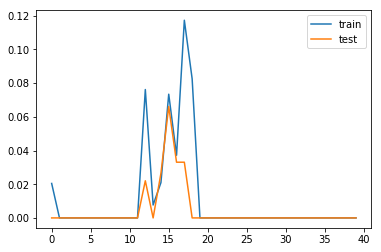

In [139]:
model_weights =(plt.plot(history.history['sensitivity'],label='train'),
plt.plot(history.history['val_sensitivity'],label='test'),
plt.legend(),
plt.show())
model_weights;

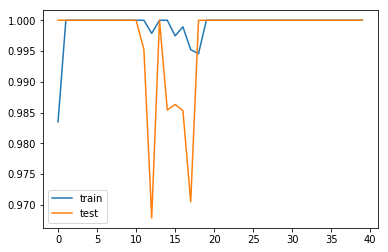

In [140]:
model_weights =(plt.plot(history.history['specificity'],label='train'),
plt.plot(history.history['val_specificity'],label='test'),
plt.legend(),
plt.show())
model_weights;

In [172]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size + 1, verbose = 1)
# y_pred = np.argmax(y_pred, axis = 1)

/anaconda3/lib/python3.6/site-packages/PIL/Image.py:888: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


9/9 [==============================] - 47s 5s/step


In [174]:
y_pred

array([[0.47516787],
       [0.48403135],
       [0.49263012],
       [0.4921523 ],
       [0.4934527 ],
       [0.48879978],
       [0.501606  ],
       [0.49447313],
       [0.47308326],
       [0.52247477],
       [0.50521195],
       [0.47784504],
       [0.49337822],
       [0.47046724],
       [0.5049718 ],
       [0.45173213],
       [0.4864606 ],
       [0.49493232],
       [0.46654993],
       [0.4620792 ],
       [0.49124202],
       [0.47124386],
       [0.4787866 ],
       [0.46501672],
       [0.5051309 ],
       [0.49386582],
       [0.5089578 ],
       [0.50792634],
       [0.4904607 ],
       [0.48577324],
       [0.4886738 ],
       [0.47760445],
       [0.4817544 ],
       [0.48589456],
       [0.47329882],
       [0.49851966],
       [0.4890041 ],
       [0.4564451 ],
       [0.47937062],
       [0.49097934],
       [0.45596832],
       [0.49368078],
       [0.49034607],
       [0.48223162],
       [0.4989224 ],
       [0.52195364],
       [0.48144117],
       [0.485

In [177]:
nb_validation_samples

271

In [201]:
y_test = []
# for _ in range(nb_validation_samples // batch_size + 1):
for _ in range(30):
    temp = next(validation_generator)
    y_test.extend( temp[1] )

len(y_test)

/anaconda3/lib/python3.6/site-packages/PIL/Image.py:888: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


904

In [197]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size + 1, verbose = 1)
y_pred = np.argmax(y_pred, axis = 1)

/anaconda3/lib/python3.6/site-packages/PIL/Image.py:888: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


9/9 [==============================] - 41s 5s/step


In [185]:
test_predictions = []
for _ in range(nb_validation_samples // batch_size + 1):
    temp = next(validation_generator)
    test_predictions += [(model.predict(temp[0]), temp[1])]

/anaconda3/lib/python3.6/site-packages/PIL/Image.py:888: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [189]:
y_pred = 1 * (np.concatenate([x[0] for x in test_predictions]) > .65)

In [190]:
y_test = np.concatenate([x[1] for x in test_predictions])

In [193]:
y_pred

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [194]:
y_test

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [192]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[239   0]
 [ 35   0]]
             precision    recall  f1-score   support

        0.0       0.87      1.00      0.93       239
        1.0       0.00      0.00      0.00        35

avg / total       0.76      0.87      0.81       274



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [196]:
pd.DataFrame(confusion_matrix(y_test, y_pred),columns=['PN','PP'],index=['AN','AP'])

,PN,PP
AN,239,0
AP,35,0


In [204]:
train_generator.__dict__ # see defined train_clean : 0, train_polluted : 1

{'batch_index': 0,
 'batch_size': 32,
 'class_indices': {'train_clean': 0, 'train_polluted': 1},
 'class_mode': 'binary',
 'classes': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [203]:
validation_generator.__dict__

{'batch_index': 4,
 'batch_size': 32,
 'class_indices': {'test_clean1': 0, 'test_polluted1': 1},
 'class_mode': 'binary',
 'classes': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       dtype=int32),
 'color_mode': 'rgb',
 'data_fo